In [1]:
import os
os.chdir('../')

In [2]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Paths

In [3]:
affwild2_path = '/datasets/affwild2'
affwild2_videos = os.path.join(affwild2_path, 'videos/train')
affwild2_arousal = os.path.join(affwild2_path, 'annotations/train/arousal')
affwild2_valence = os.path.join(affwild2_path, 'annotations/train/valence')

# Utility Functions

In [4]:
def read_videos(path, max_frames=5):
    
    vid = cv2.VideoCapture(path)
    frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid.get(cv2.CAP_PROP_FPS)
    frame_pipeline_out = []

    for i in range(frame_count):
        ret, frame = vid.read()

        if not ret or i == max_frames:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.show()

    vid.release()
    
    return frame_count, fps

def read_frame(path, idx=0):
    
    vid = cv2.VideoCapture(path)
    frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid.get(cv2.CAP_PROP_FPS)
    frame_pipeline_out = []

    for i in range(frame_count):
        ret, frame = vid.read()

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if not ret or i == idx:
            break
            
    vid.release()
    
    return cv2.resize(frame, (128, 128)), frame_count, fps

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()
    
def get_face(img, detections, with_keypoints=True):
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

    return ymin, xmin, ymax, xmax

# Explore Model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

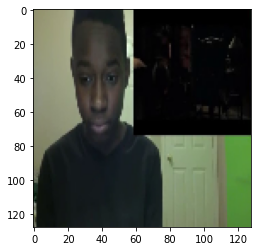

In [6]:
sample_path = os.path.join(affwild2_videos, '430.mp4')
sample_frame, frame_count, fps = read_frame(sample_path, idx=200)

plt.imshow(sample_frame)

In [7]:
from models.blazeface import BlazeFace

front_net = BlazeFace().to(device)
front_net.load_weights("weights/blazeface.pth")
front_net.load_anchors("weights/anchors.npy")
back_net = BlazeFace(back_model=True).to(device)
back_net.load_weights("weights/blazefaceback.pth")
back_net.load_anchors("weights/anchorsback.npy")

In [8]:
front_detections = front_net.predict_on_image(sample_frame)
front_detections.shape

torch.Size([1, 17])

Found 1 faces


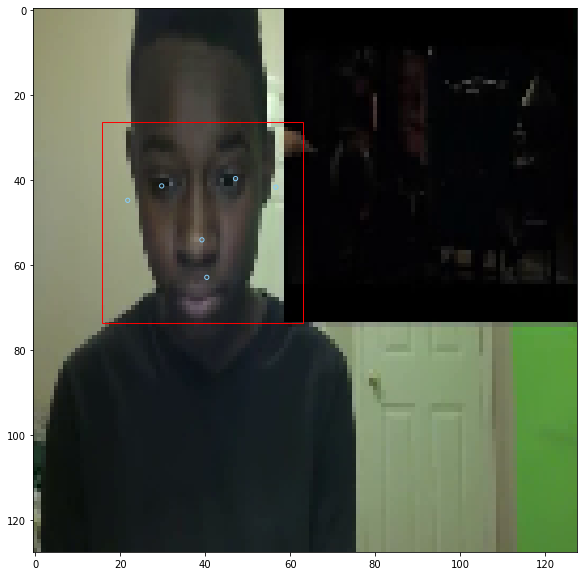

In [9]:
plot_detections(sample_frame, front_detections)

In [10]:
ymin, xmin, ymax, xmax = get_face(sample_frame, front_detections)

Found 1 faces


In [11]:
face = sample_frame[int(ymin):int(ymax), int(xmin):int(xmax), :]

In [13]:
face = cv2.resize(face, (128, 128))

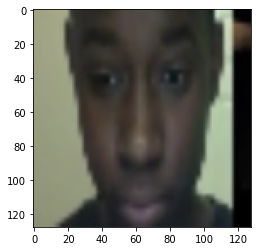

In [14]:
plt.imshow(face)

In [15]:
from models.mobilenetv2 import mobilenetv2

In [16]:
model = mobilenetv2()

In [17]:
model.load_state_dict(torch.load('weights/mobilenetv2_128x128-fd66a69d.pth'))

<All keys matched successfully>

In [19]:
face.shape

(128, 128, 3)

In [30]:
model.classifier = nn.Linear(model.classifier.in_features, 2)

In [31]:
out = model(torch.from_numpy(face.astype(np.float32)).permute(2, 0, 1).unsqueeze(0))

In [34]:
out

tensor([[0.1771, 0.5201]], grad_fn=<AddmmBackward>)